## Segmentation of healthy leaf and leaf area calculation

In [1]:
import os
import glob
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
""" Dataset path"""
leaf_data_path = "../Data/leaf/" #"../Data/leaf"
os.path.exists(leaf_data_path)

True

In [3]:
images = glob.glob(leaf_data_path+"/*.jpg")
images

['../Data/leaf/63.jpg',
 '../Data/leaf/823.jpg',
 '../Data/leaf/1409.jpg',
 '../Data/leaf/189.jpg',
 '../Data/leaf/77.jpg',
 '../Data/leaf/837.jpg',
 '../Data/leaf/1353.jpg',
 '../Data/leaf/1435.jpg',
 '../Data/leaf/1421.jpg',
 '../Data/leaf/1347.jpg',
 '../Data/leaf/638.jpg',
 '../Data/leaf/1390.jpg',
 '../Data/leaf/604.jpg',
 '../Data/leaf/162.jpg',
 '../Data/leaf/176.jpg',
 '../Data/leaf/88.jpg',
 '../Data/leaf/610.jpg',
 '../Data/leaf/1384.jpg',
 '../Data/leaf/1179.jpg',
 '../Data/leaf/1637.jpg',
 '../Data/leaf/1151.jpg',
 '../Data/leaf/1145.jpg',
 '../Data/leaf/1623.jpg',
 '../Data/leaf/348.jpg',
 '../Data/leaf/360.jpg',
 '../Data/leaf/406.jpg',
 '../Data/leaf/1192.jpg',
 '../Data/leaf/1186.jpg',
 '../Data/leaf/412.jpg',
 '../Data/leaf/374.jpg',
 '../Data/leaf/1019.jpg',
 '../Data/leaf/599.jpg',
 '../Data/leaf/1743.jpg',
 '../Data/leaf/1025.jpg',
 '../Data/leaf/1031.jpg',
 '../Data/leaf/228.jpg',
 '../Data/leaf/214.jpg',
 '../Data/leaf/572.jpg',
 '../Data/leaf/566.jpg',
 '../Data/

1. Using Image processing only technique

In [4]:
class SegmentLeaf:
    def __init__(self):
        pass
        
    def __call__(self,image): 
        mask = self.remove_background(image)
        contour,area = self.find_contour(mask)
        return mask,contour,area
    
    def remove_background(self,image):
        # Gaussia blur
        blured = cv2.GaussianBlur(image,(1,1),0)
        # Convert RGB image to HSV
        leaf_hsv = cv2.cvtColor(blured,cv2.COLOR_BGR2HSV)
        # Get mask from the S and V channels
        SV_channel = leaf_hsv.copy()
        # Set the H channel to zero
        SV_channel[...,0] = np.zeros((leaf_hsv.shape[0],leaf_hsv.shape[1]))
        # get binary mask
        mask = cv2.inRange(SV_channel,(0,0,80),(0,50,255))
        # Invert mask, White areas represent green components and black the background
        mask = cv2.bitwise_not(mask)
        return mask
    
    def find_contour(self,mask):
        # find all contours on the maks
        contours, heirarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # filter the largest contour
        largest_contour = max(contours,key=cv2.contourArea)
        #print(largest_contour)
        # get area of the largest contour
        contour_area = cv2.contourArea(largest_contour)
        return largest_contour,contour_area

2. Using Unet

In [5]:
import sys
import torch

sys.path.append(os.path.abspath(".."))
from elunet.elunet import ELUnet

device = torch.device("cpu")
print(f"torch version : {torch.__version__}")

torch version : 1.12.1


In [10]:
elunet = ELUnet(3,1,16)
healthy_checkpoint = torch.load("../elunet_checkpoint/elunet_healthy_leaf_2023-03-05.pth",map_location=device)
elunet.load_state_dict(healthy_checkpoint)

<All keys matched successfully>

In [11]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((256,256))])

#### Segment sample image

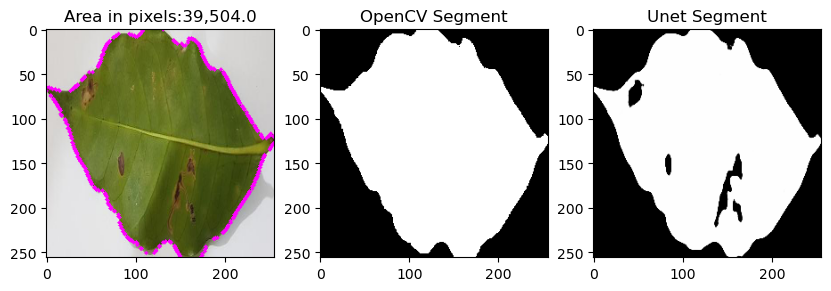

In [22]:
with torch.no_grad():
    elunet.eval()
    # read image
    image = cv2.imread(random.choice(images))
    image = cv2.resize(image,(256,256))
    # bgr to rgb
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    tensor_image = transform(image)
    
    # Init leaf segment
    segment = SegmentLeaf()
    mask,contour,area = segment(image)
    # Overlay image and mask
    segmented_leaf = cv2.bitwise_and(image,image,mask=mask)
    cv2.drawContours(image, contour, -1, (255,0,255), 3)

    # Using Unet
    
    tensor_image = tensor_image.unsqueeze(0).to(device)
    

    unet_mask = elunet(tensor_image)
    unet_mask = unet_mask[0].permute(1,2,0).detach().numpy()


    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.title(f"Area in pixels:{area:,}")
    plt.imshow(image)

    plt.subplot(1,3,2)
    plt.imshow(mask,cmap="gray")
    plt.title(f"OpenCV Segment")

    
    healthy_pixels = np.sum(unet_mask)

    plt.subplot(1,3,3)
    plt.imshow(unet_mask,cmap="gray")
    plt.title(f"Unet Segment")

    plt.show()